# Manifesto forewords: proof of concept

## Preparing and cleaning forewords data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('wordnet')

from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

forewords = pd.read_csv('manifestos.csv')
forewords['year'] = pd.to_datetime(forewords.year)
display(forewords.head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,party,year,leader_name,url,foreword
0,LAB,1945-06-05,Clement Attlee,http://labour-party.org.uk/manifestos/1945/194...,Victory is assured for us and our allies in th...
1,CON,1945-06-05,Winston Churchill,http://www.conservativemanifesto.com/1945/1945...,I had hoped to preserve the Coalition Governme...
2,LIB,1945-06-05,Archibald Sinclair,http://www.libdemmanifesto.com/1945/1945-liber...,"The Liberal Party, having for five years forme..."
3,LAB,1950-02-23,Clement Attlee,http://labour-party.org.uk/manifestos/1950/195...,When the Labour Party published Let Us Face th...
4,CON,1950-02-23,Winston Churchill,http://www.conservativemanifesto.com/1950/1950...,As Leader of the Conservative and Unionist Par...


In [2]:
def clean(text):
    def replace_whitespace(text):
        return text.replace('\n',' ')
    
    def delete_punctuation(text):
        punctuation = '\,./|<>?;#:@~[]{}`!"£$%^&*()-=_+\''
        for punct in punctuation:
            text = text.replace(punct, ' ')
        return text
    
    no_whitespace = replace_whitespace(text)
    no_punct = delete_punctuation(no_whitespace)
    
    while '  ' in no_punct:
        no_punct = no_punct.replace('  ',' ')

    text_list = [word.lower() for word in no_punct.split(' ') if word!='']

    return text_list

In [3]:
def clean_to_paragraphs(text):
    def replace_whitespace(text):
        return text.split('\n')
    
    def delete_punctuation(text):
        punctuation = '\,./|<>?;#:@~[]{}`!"£$%^&*()-=_+\''
        for punct in punctuation:
            text = text.replace(punct, ' ')
        return text
    
    no_whitespace = replace_whitespace(text)
    no_punct = [delete_punctuation(paragraph) for paragraph in no_whitespace]
    
    for idx,paragraph in enumerate(no_punct):
        while '  ' in paragraph:
            paragraph = paragraph.replace('  ',' ')
            no_punct[idx] = paragraph

    text_list = [[word.lower() for word in paragraph.split(' ') if word!=''] for paragraph in no_punct if paragraph!='']

    return text_list

In [4]:
forewords['cleaned'] = forewords.foreword.apply(lambda text: clean(text))
display(forewords.head())

,party,year,leader_name,url,foreword,cleaned
0,LAB,1945-06-05,Clement Attlee,http://labour-party.org.uk/manifestos/1945/194...,Victory is assured for us and our allies in th...,"[victory, is, assured, for, us, and, our, alli..."
1,CON,1945-06-05,Winston Churchill,http://www.conservativemanifesto.com/1945/1945...,I had hoped to preserve the Coalition Governme...,"[i, had, hoped, to, preserve, the, coalition, ..."
2,LIB,1945-06-05,Archibald Sinclair,http://www.libdemmanifesto.com/1945/1945-liber...,"The Liberal Party, having for five years forme...","[the, liberal, party, having, for, five, years..."
3,LAB,1950-02-23,Clement Attlee,http://labour-party.org.uk/manifestos/1950/195...,When the Labour Party published Let Us Face th...,"[when, the, labour, party, published, let, us,..."
4,CON,1950-02-23,Winston Churchill,http://www.conservativemanifesto.com/1950/1950...,As Leader of the Conservative and Unionist Par...,"[as, leader, of, the, conservative, and, union..."


# Measuring persuasion

## Variables of interest

In [5]:
# Sentiment polarity trained on data from UK Hansard contributions
# See Rheault, et al. (2016) 'Measuring emotion in parliamentary debates with automated text analysis'
sentiment = pd.read_csv('https://raw.githubusercontent.com/lrheault/emotion/master/lexicon-polarity.csv')
sentiment_dict = {lemma:sentiment.polarity[idx] for idx,lemma in enumerate(sentiment.lemma)}

In [6]:
# Hedges taken from Hyland (2019) Metadiscourse: Exploring Interaction in Writing
hedge_list = ['about','almost','apparent','apparently','appear','appeared','appears','approximately',
              'argue','argued','argues','around','assume','assumed','broadly','claim','claimed','claims',
              'could','couldn','doubt','doubtful','essentially','estimate','estimated','fairly','feel',
              'feels','felt','frequently','generally','guess','indicate','indicated','indicates','largely',
              'likely','mainly','may','maybe','might','mostly','often','opinion','ought','perhaps',
              'perspective','plausible','plausibly','possible','possibly','postulate','postulated',
              'postulates','presumable','presumably','probable','probably','quite','rather','relatively',
              'roughly','seems','should','sometimes','somewhat','suggest','suggested','suggests','suppose',
              'supposed','supposes','suspect','suspects','tend','tended','tends','typical','typically',
              'uncertain','uncertainly','unclear','unclearly','unlikely','usually','would','wouldn','view']

In [7]:
def measure_persuasion(text_list, 
                       sentiment_dict=sentiment_dict, hedge_list=hedge_list, 
                       pos_threshold=0.5,neg_threshold=-0.5):
    
    # Set-up lemmatiser
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    # We need a lemmatised text list for matching with the sentiment dict
    lemmatised_text_list = [wnl.lemmatize(word) for word in text_list]
    
    # Number of definite articles, i.e. 'the', in the text
    num_definite_articles = sum([1 for word in text_list if word=='the'])
    share_definite_articles = num_definite_articles/len(text_list)
    
    # Number of positive/negative words
    sentiment = [sentiment_dict[lemma] if lemma in sentiment_dict.keys() else np.nan for lemma in lemmatised_text_list]
    num_positive_words = sum([1 for word_sent in sentiment if word_sent >= pos_threshold])
    share_positive_words = num_positive_words/len(text_list)
    num_negative_words = sum([1 for word_sent in sentiment if word_sent <= neg_threshold])
    share_negative_words = num_negative_words/len(text_list)
    
    # Number of personal pronouns (1st and 2nd person)
    num_personal_pronouns = sum([1 for word in text_list if word in ['i','you','we','us']])
    share_personal_pronouns = num_personal_pronouns/len(text_list)
    
    # Number of impersonal pronouns (3rd person)
    num_impersonal_pronouns = sum([1 for word in text_list if word in ['they','them']])
    share_impersonal_pronouns = num_impersonal_pronouns/len(text_list)
    
    # Number of hedges
    num_hedges = sum([1 for word in text_list if word in hedge_list])
    share_hedges = num_hedges/len(text_list)
    
    # Foreword length
    length = len(text_list)
    
    # TO DO: Add scalar word-level attributes (arousal, concreteness, dominance, valence)
    # Add word entropy/type-to-token ratio
    
    feature_dict = {'length':length,
                    'share_definite_articles':share_definite_articles,
                    'share_positive_words':share_positive_words,
                    'share_negative_words':share_negative_words,
                    'share_personal_pronouns':share_personal_pronouns,
                    'share_impersonal_pronouns':share_impersonal_pronouns,
                    'share_hedges':share_hedges}
    
    return feature_dict

In [8]:
res = forewords.cleaned.apply(measure_persuasion)

## Time series plots

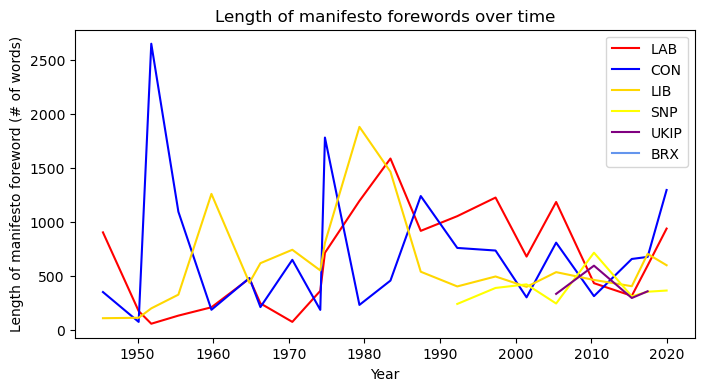

In [9]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}
for party in forewords.party.unique():
    party_mask = forewords.party.apply(lambda x: x==party).to_list()
    ax.plot(forewords.year[party_mask],
            [x['length'] for x in res[party_mask].to_list()],
            color=party_colors[party], label=party)
plt.xlabel("Year")
plt.ylabel("Length of manifesto foreword (# of words)")
plt.title("Length of manifesto forewords over time")
plt.legend()
plt.show()

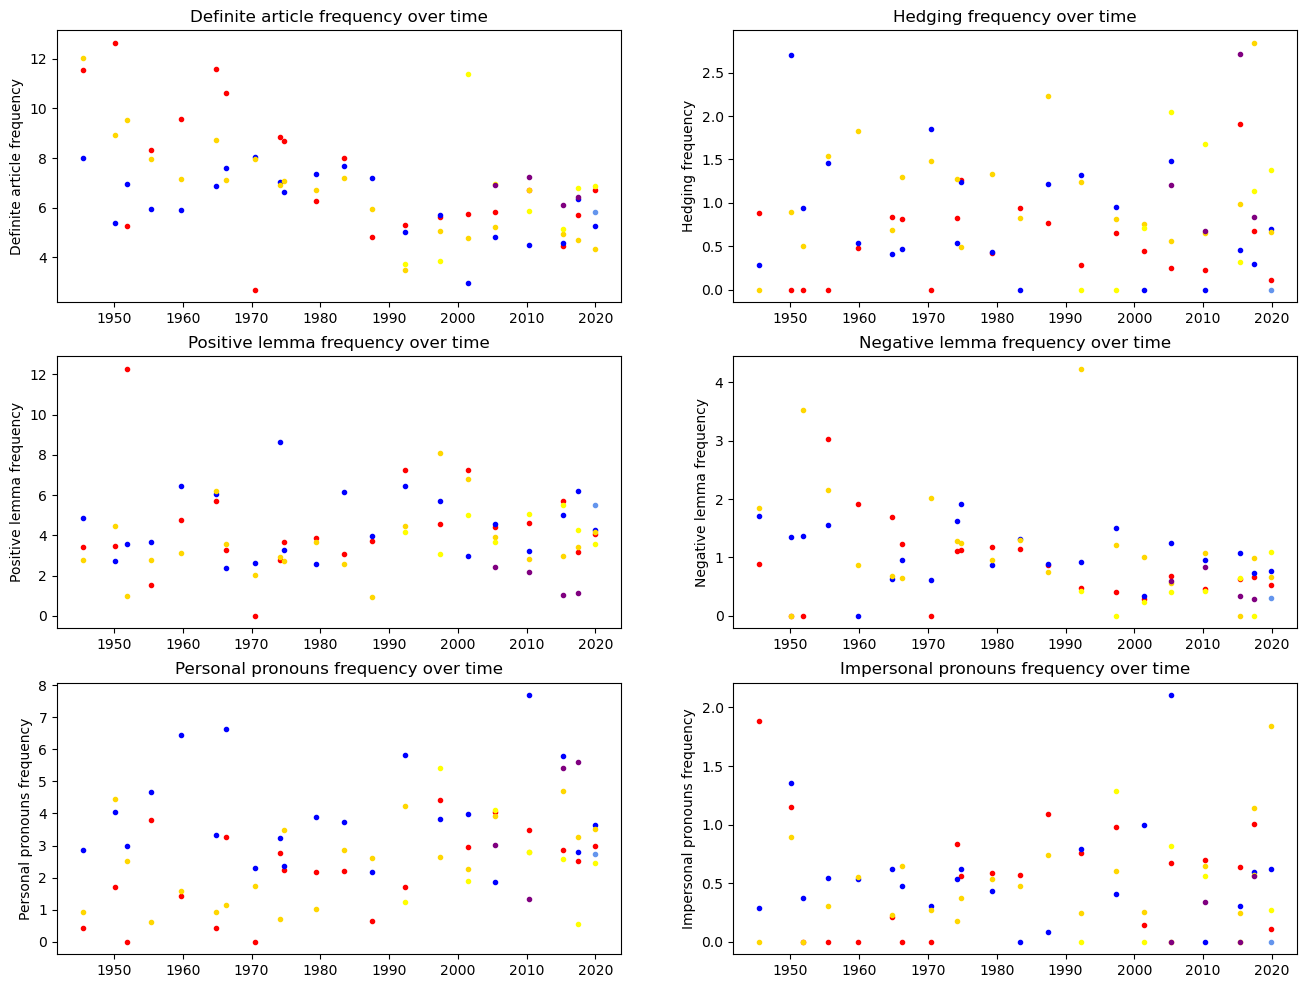

In [10]:
fig,axs = plt.subplots(3,2, figsize=(16,12))
var_list = {'share_definite_articles':['Definite article frequency','Definite article frequency (% of total words)'],
            'share_hedges':['Hedging frequency','Hedging frequency (% of total words)'],
            'share_positive_words':['Positive lemma frequency','Positive lemma frequency (% of total words)'],
            'share_negative_words':['Negative lemma frequency','Negative lemma frequency (% of total words)'],
            'share_personal_pronouns':['Personal pronouns frequency','Personal pronouns frequency (% of total words)'],
            'share_impersonal_pronouns':['Impersonal pronouns frequency','Impersonal pronouns frequency (% of total words)']}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

for idx,variable in enumerate(var_list.keys()):
    for party in forewords.party.unique():
        party_mask = forewords.party.apply(lambda x: x==party).to_list()
        axs[idx//2][idx%2].plot(forewords.year[party_mask],
                                [100*x[variable] for x in res[party_mask].to_list()],
                                '.', ls='', color=party_colors[party], label=party)
        axs[idx//2][idx%2].set_ylabel(var_list[variable][0])
        axs[idx//2][idx%2].set_title("{} over time".format(var_list[variable][0]))
plt.show()

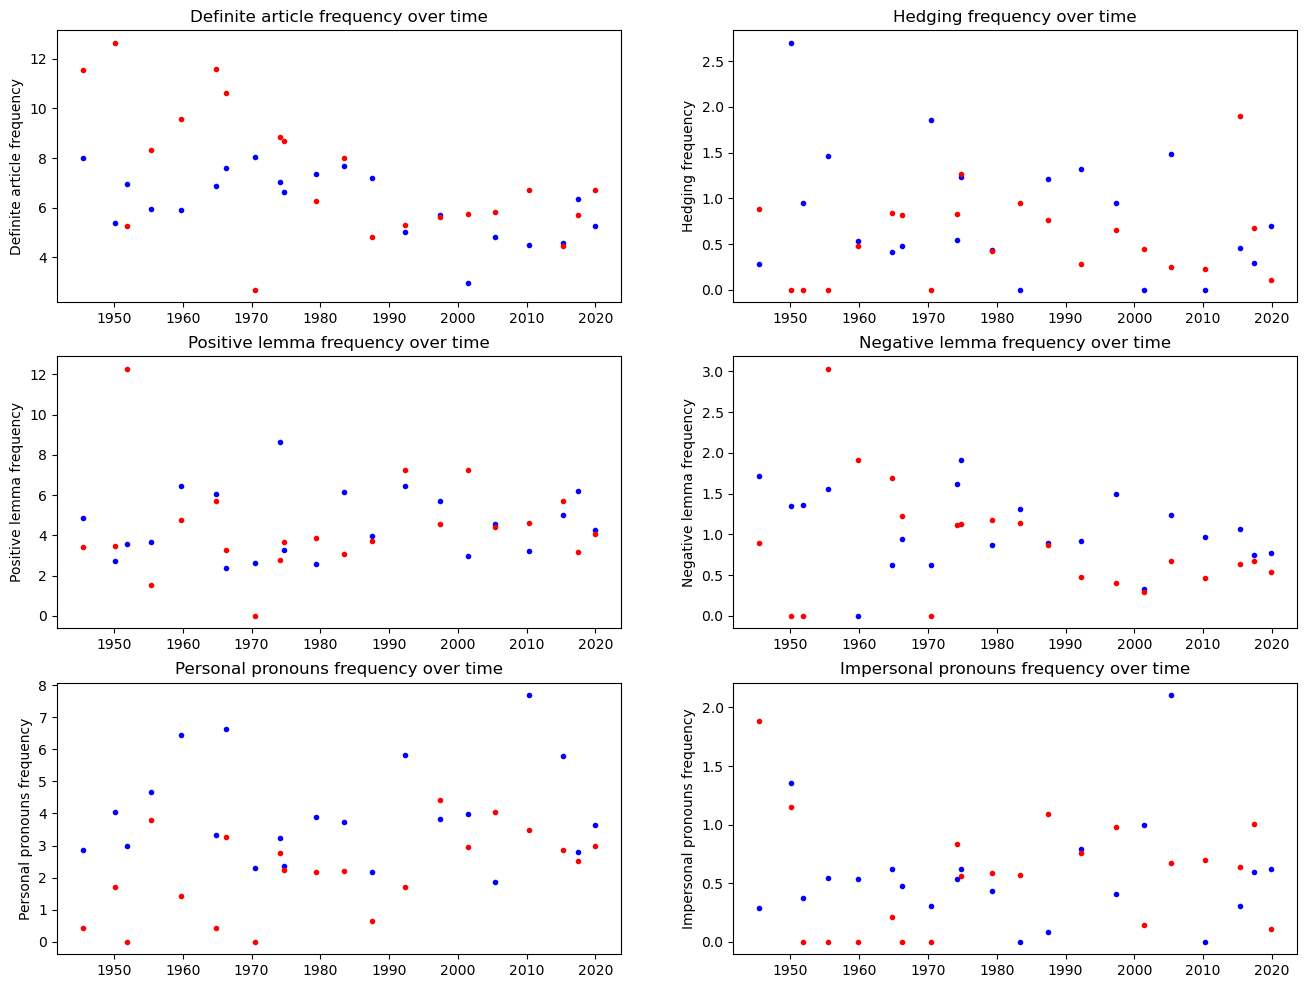

In [11]:
fig,axs = plt.subplots(3,2, figsize=(16,12))
var_list = {'share_definite_articles':['Definite article frequency','Definite article frequency (% of total words)'],
            'share_hedges':['Hedging frequency','Hedging frequency (% of total words)'],
            'share_positive_words':['Positive lemma frequency','Positive lemma frequency (% of total words)'],
            'share_negative_words':['Negative lemma frequency','Negative lemma frequency (% of total words)'],
            'share_personal_pronouns':['Personal pronouns frequency','Personal pronouns frequency (% of total words)'],
            'share_impersonal_pronouns':['Impersonal pronouns frequency','Impersonal pronouns frequency (% of total words)']}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

for idx,variable in enumerate(var_list.keys()):
    for party in ['CON','LAB']:
        party_mask = forewords.party.apply(lambda x: x==party).to_list()
        axs[idx//2][idx%2].plot(forewords.year[party_mask],
                                [100*x[variable] for x in res[party_mask].to_list()],
                                '.', ls='', color=party_colors[party], label=party)
        axs[idx//2][idx%2].set_ylabel(var_list[variable][0])
        axs[idx//2][idx%2].set_title("{} over time".format(var_list[variable][0]))
plt.show()

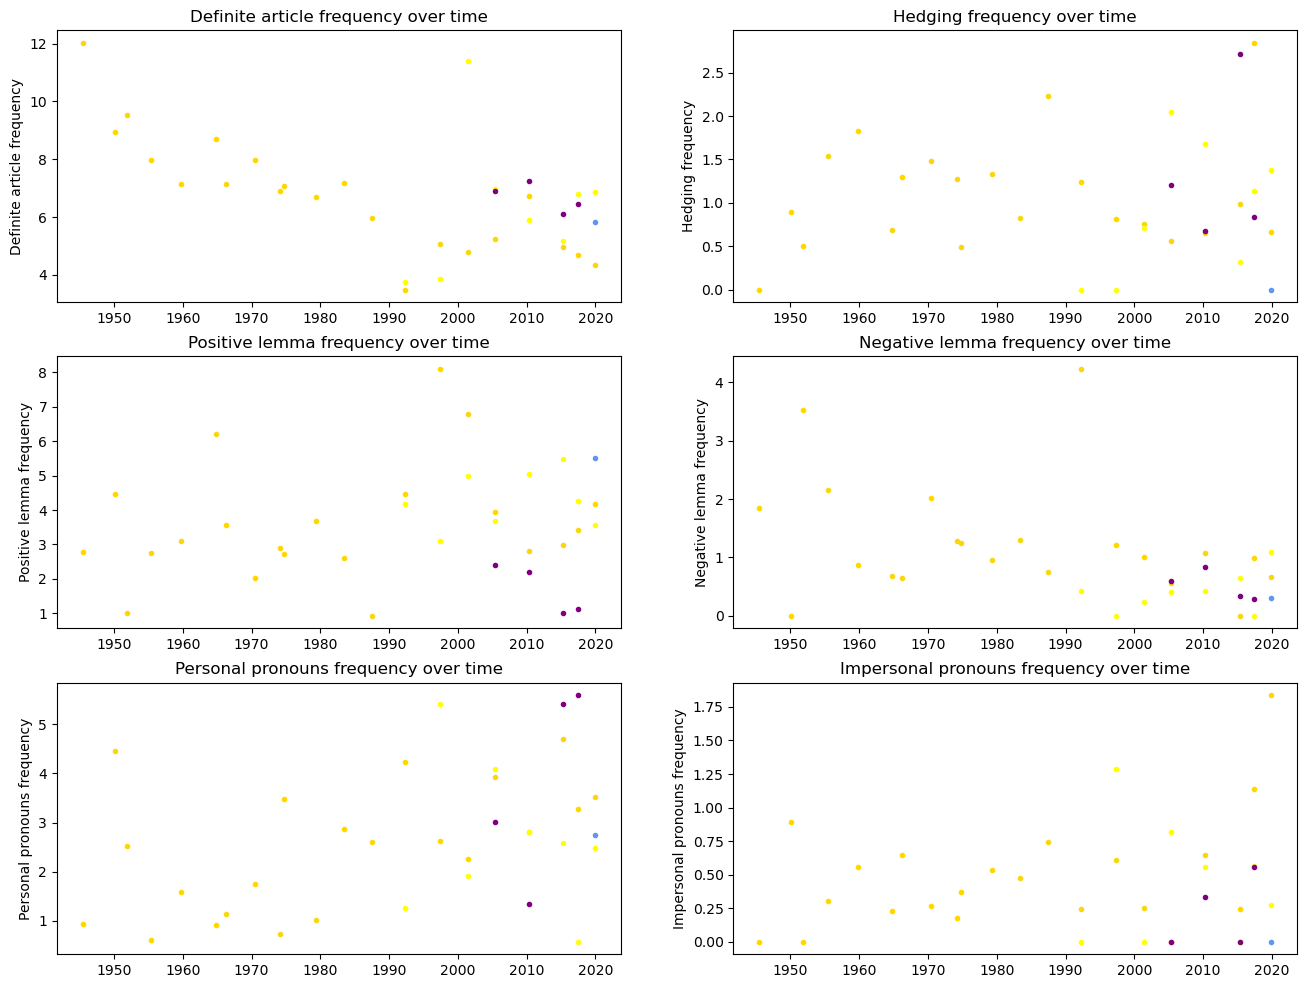

In [12]:
fig,axs = plt.subplots(3,2, figsize=(16,12))
var_list = {'share_definite_articles':['Definite article frequency','Definite article frequency (% of total words)'],
            'share_hedges':['Hedging frequency','Hedging frequency (% of total words)'],
            'share_positive_words':['Positive lemma frequency','Positive lemma frequency (% of total words)'],
            'share_negative_words':['Negative lemma frequency','Negative lemma frequency (% of total words)'],
            'share_personal_pronouns':['Personal pronouns frequency','Personal pronouns frequency (% of total words)'],
            'share_impersonal_pronouns':['Impersonal pronouns frequency','Impersonal pronouns frequency (% of total words)']}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

for idx,variable in enumerate(var_list.keys()):
    for party in ['LIB','SNP','UKIP','BRX']:
        party_mask = forewords.party.apply(lambda x: x==party).to_list()
        axs[idx//2][idx%2].plot(forewords.year[party_mask],
                                [100*x[variable] for x in res[party_mask].to_list()],
                                '.', ls='', color=party_colors[party], label=party)
        axs[idx//2][idx%2].set_ylabel(var_list[variable][0])
        axs[idx//2][idx%2].set_title("{} over time".format(var_list[variable][0]))
plt.show()

## Clustering

### Extracted features

In [13]:
forewords['features'] = res.apply(lambda dic: list(dic.values()))
display(forewords.head())

,party,year,leader_name,url,foreword,cleaned,features
0,LAB,1945-06-05,Clement Attlee,http://labour-party.org.uk/manifestos/1945/194...,Victory is assured for us and our allies in th...,"[victory, is, assured, for, us, and, our, alli...","[902, 0.11529933481152993, 0.03436807095343681..."
1,CON,1945-06-05,Winston Churchill,http://www.conservativemanifesto.com/1945/1945...,I had hoped to preserve the Coalition Governme...,"[i, had, hoped, to, preserve, the, coalition, ...","[350, 0.08, 0.04857142857142857, 0.01714285714..."
2,LIB,1945-06-05,Archibald Sinclair,http://www.libdemmanifesto.com/1945/1945-liber...,"The Liberal Party, having for five years forme...","[the, liberal, party, having, for, five, years...","[108, 0.12037037037037036, 0.02777777777777777..."
3,LAB,1950-02-23,Clement Attlee,http://labour-party.org.uk/manifestos/1950/195...,When the Labour Party published Let Us Face th...,"[when, the, labour, party, published, let, us,...","[174, 0.12643678160919541, 0.03448275862068965..."
4,CON,1950-02-23,Winston Churchill,http://www.conservativemanifesto.com/1950/1950...,As Leader of the Conservative and Unionist Par...,"[as, leader, of, the, conservative, and, union...","[74, 0.05405405405405406, 0.02702702702702703,..."


In [14]:
from sklearn import cluster,preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
kmeans = cluster.KMeans(n_clusters=6)

X = np.array(forewords.features.to_list())
scaled_X = scaler.fit_transform(X)
clusters = pd.Series(kmeans.fit_predict(scaled_X))

In [15]:
for cluster_num in range(5):
    cluster_mask = clusters.apply(lambda x:x==cluster_num)
    print("Cluster {}".format(cluster_num))
    for row in forewords[cluster_mask].iterrows():
        print('\tYear: {}; Party: {}; Leader: {}'.format(row[1].year.year, row[1].party, row[1].leader_name))

Cluster 0
	Year: 1945; Party: LAB; Leader: Clement Attlee
	Year: 1945; Party: LIB; Leader: Archibald Sinclair
	Year: 1950; Party: LAB; Leader: Clement Attlee
	Year: 1964; Party: LAB; Leader: Harold Wilson
	Year: 1964; Party: LIB; Leader: Jo Grimond
	Year: 1966; Party: LAB; Leader: Harold Wilson
	Year: 2001; Party: SNP; Leader: John Swinney
Cluster 1
	Year: 1950; Party: LIB; Leader: Clement Davies
	Year: 1959; Party: CON; Leader: Harold Macmillan
	Year: 1966; Party: CON; Leader: Edward Heath
	Year: 1979; Party: CON; Leader: Margaret Thatcher
	Year: 1992; Party: CON; Leader: John Major
	Year: 1997; Party: LAB; Leader: Tony Blair
	Year: 1997; Party: SNP; Leader: Alex Salmond
	Year: 2001; Party: CON; Leader: William Hague
	Year: 2005; Party: LAB; Leader: Tony Blair
	Year: 2010; Party: LAB; Leader: Gordon Brown
	Year: 2010; Party: CON; Leader: David Cameron
	Year: 2015; Party: CON; Leader: David Cameron
	Year: 2015; Party: LIB; Leader: Nick Clegg
	Year: 2017; Party: UKIP; Leader: Paul Nutta

In [109]:
X = np.array(forewords.features.to_list())
scaled_X = scaler.fit_transform(X)

tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=20, n_iter=5000, random_state=0)
tsne_results = tsne.fit_transform(scaled_X)

C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


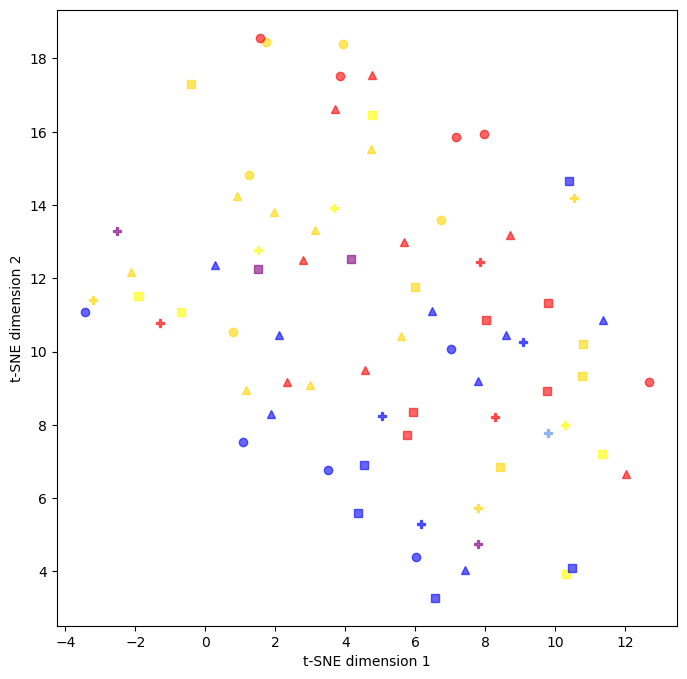

In [110]:
symbol_dict = {(1945,1960):'o',
               (1961,1990):'^',
               (1991,2014):'s',
               (2015,2025):'P'}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}


fig, ax = plt.subplots(1, figsize=(8,8))

for idx,row in enumerate(forewords.iterrows()):
    ax.plot(tsne_results[idx,0], tsne_results[idx,1],
            alpha=0.6, color=party_colors[row[1].party], 
            marker=symbol_dict[[(start,end) for (start,end) in symbol_dict.keys() if row[1].year.year>=start and row[1].year.year<=end][0]])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()

### Word embeddings

In [19]:
import pickle
# Load FastText vecs from disk
vectors_path = 'fasttext_vectors.p' 
with open(vectors_path, 'rb') as f:
    vectors = pickle.load(f)
    
missing_word = [np.nan]*len(vectors['word'])

foreword_vecs = forewords.cleaned.apply(lambda text_list: [vectors[word] if word in vectors.keys() and word not in stops else missing_word for word in text_list])
avg_foreword_vecs = foreword_vecs.apply(lambda vecs: list(np.nanmean(vecs, axis=0))).to_list()

# concat the vectors for the first 50 words:
first_50_word_vecs = foreword_vecs.apply(lambda vecs: [val for lst in vecs[:50] for val in lst]).to_list()

#### Average embeddings

In [21]:
from sklearn import cluster,manifold

n_clusters=4

kmeans = cluster.KMeans(n_clusters=n_clusters)

X = np.array(avg_foreword_vecs)
clusters = pd.Series(kmeans.fit_predict(X))

for cluster_num in range(n_clusters):
    cluster_mask = clusters.apply(lambda x:x==cluster_num)
    print("Cluster {}".format(cluster_num))
    for row in forewords[cluster_mask].iterrows():
        print('\tYear: {}; Party: {}; Leader: {}'.format(row[1].year.year, row[1].party, row[1].leader_name))

Cluster 0
	Year: 1945; Party: LIB; Leader: Archibald Sinclair
	Year: 1951; Party: LAB; Leader: Clement Attlee
	Year: 1951; Party: CON; Leader: Winston Churchill
	Year: 1955; Party: LIB; Leader: Clement Davies
	Year: 1964; Party: LAB; Leader: Harold Wilson
	Year: 1964; Party: CON; Leader: Alec Douglas-Home
	Year: 1964; Party: LIB; Leader: Jo Grimond
	Year: 1966; Party: LIB; Leader: Jo Grimond
	Year: 1970; Party: CON; Leader: Edward Heath
	Year: 1974; Party: LIB; Leader: Jeremy Thorpe
	Year: 1974; Party: LAB; Leader: Harold Wilson
	Year: 1974; Party: CON; Leader: Edward Heath
	Year: 1979; Party: LAB; Leader: James Callaghan
	Year: 1979; Party: LIB; Leader: David Steel
	Year: 1983; Party: CON; Leader: Margaret Thatcher
	Year: 1983; Party: LIB; Leader: David Steel
	Year: 1987; Party: LAB; Leader: Neil Kinnock
	Year: 1987; Party: CON; Leader: Margaret Thatcher
	Year: 1992; Party: LAB; Leader: Neil Kinnock
	Year: 1997; Party: CON; Leader: John Major
	Year: 1997; Party: LIB; Leader: Paddy Ash

C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


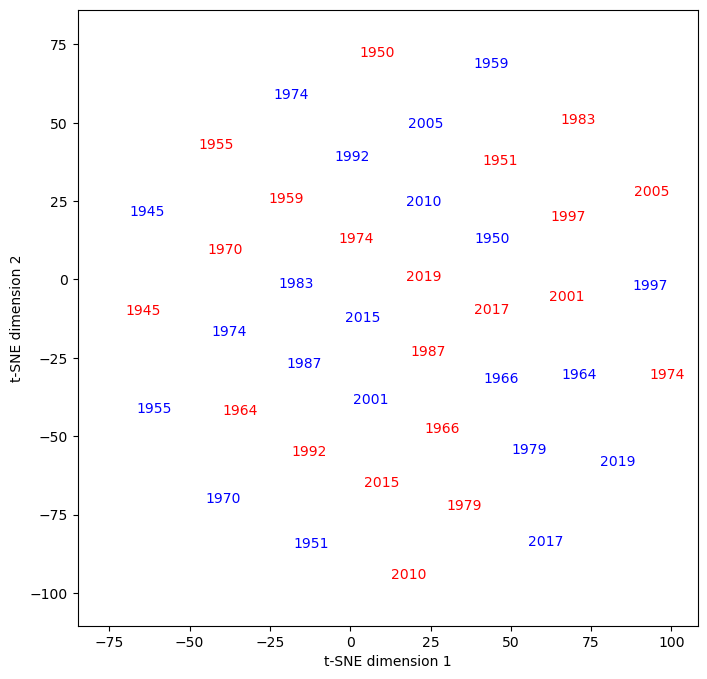

In [22]:
# Train t-SNE
tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=50, n_iter=5000, random_state=0)

main_party_mask = forewords.party.apply(lambda party: party in ['CON','LAB'])

tsne_results = tsne.fit_transform(X[np.where(main_party_mask.to_numpy()),:].squeeze())

party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

fig, ax = plt.subplots(1, figsize=(8,8))

ax.set_xlim(tsne_results[:,0].min()-15,
            tsne_results[:,0].max()+15)
ax.set_ylim(tsne_results[:,1].min()-15,
            tsne_results[:,1].max()+15)

for idx,row in enumerate(forewords[main_party_mask].iterrows()):
    ax.text(tsne_results[idx,0], tsne_results[idx,1], 
            row[1].year.year, color=party_colors[row[1].party])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()

#### First 50 embeddings

In [24]:
# from sklearn import cluster,manifold

# kmeans = cluster.KMeans()

# X = np.array(first_50_word_vecs)
# clusters = pd.Series(kmeans.fit_predict(X))

# for cluster_num in range(8):
#     cluster_mask = clusters.apply(lambda x:x==cluster_num)
#     print("Cluster {}".format(cluster_num))
#     for row in forewords[cluster_mask].iterrows():
#         print('\tYear: {}; Party: {}; Leader: {}'.format(row[1].year.year, row[1].party, row[1].leader_name))

In [25]:
# tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=50, n_iter=5000, random_state=0)
# tsne_results = tsne.fit_transform(X)

# party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
#                 'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

# fig, ax = plt.subplots(1, figsize=(8,8))

# ax.set_xlim(tsne_results[:,0].min()-15,
#             tsne_results[:,0].max()+15)
# ax.set_ylim(tsne_results[:,1].min()-15,
#             tsne_results[:,1].max()+15)

# for idx,row in enumerate(forewords.iterrows()):
#     ax.text(tsne_results[idx,0], tsne_results[idx,1], 
#             row[1].year.year, color=party_colors[row[1].party])
# ax.set_xlabel('t-SNE dimension 1')
# ax.set_ylabel('t-SNE dimension 2')
# plt.show()

# Analysis by paragraph

In [26]:
clean_paragraphs = forewords.foreword.apply(clean_to_paragraphs)
paragraph_list = [[idx,paragraph] for idx,foreword in enumerate(clean_paragraphs.to_list()) for paragraph in foreword]
para_df = pd.DataFrame({'idx':[paragraph[0] for paragraph in paragraph_list],
                        'paragraph':[paragraph[1] for paragraph in paragraph_list]})
para_df = para_df.merge(forewords[['party','year','leader_name']], left_on='idx', right_index=True)

## Time series

In [27]:
res = para_df.paragraph.apply(measure_persuasion)

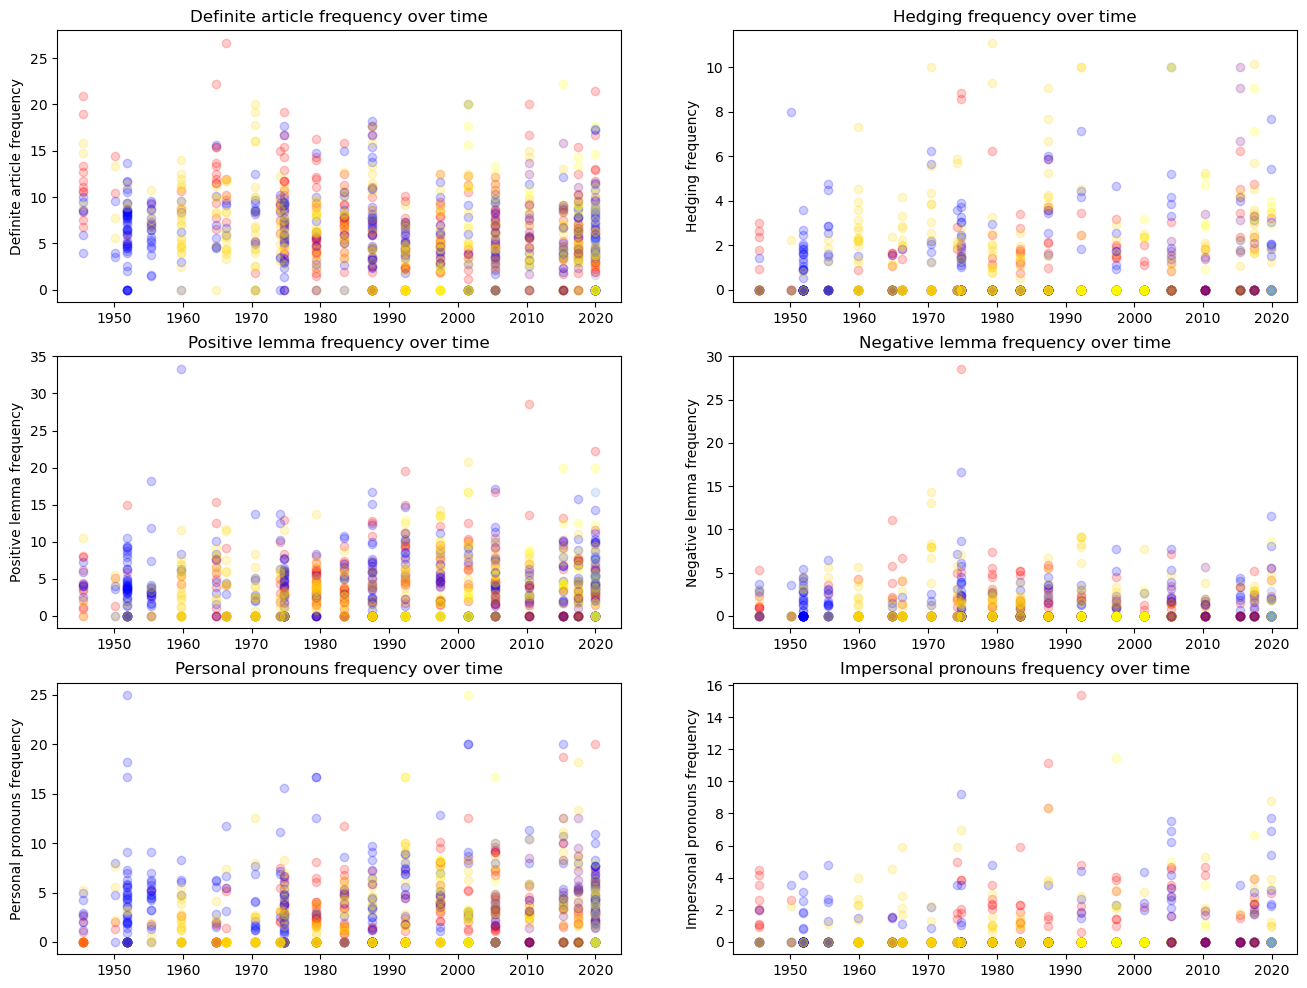

In [28]:
fig,axs = plt.subplots(3,2, figsize=(16,12))
var_list = {'share_definite_articles':['Definite article frequency','Definite article frequency (% of total words)'],
            'share_hedges':['Hedging frequency','Hedging frequency (% of total words)'],
            'share_positive_words':['Positive lemma frequency','Positive lemma frequency (% of total words)'],
            'share_negative_words':['Negative lemma frequency','Negative lemma frequency (% of total words)'],
            'share_personal_pronouns':['Personal pronouns frequency','Personal pronouns frequency (% of total words)'],
            'share_impersonal_pronouns':['Impersonal pronouns frequency','Impersonal pronouns frequency (% of total words)']}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}

for idx,variable in enumerate(var_list.keys()):
    for party in para_df.party.unique():
        party_mask = para_df.party.apply(lambda x: x==party).to_list()
        axs[idx//2][idx%2].plot(para_df.year[party_mask],
                                [100*x[variable] for x in res[party_mask].to_list()],
                                'o', ls='', color=party_colors[party], label=party,
                                alpha=0.2)
        axs[idx//2][idx%2].set_ylabel(var_list[variable][0])
        axs[idx//2][idx%2].set_title("{} over time".format(var_list[variable][0]))
plt.show()

In [115]:
X = np.array([list(para.values()) for para in res.to_list()])
scaled_X = scaler.fit_transform(X)

tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=20, n_iter=5000, random_state=0)
tsne_results = tsne.fit_transform(scaled_X)

C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


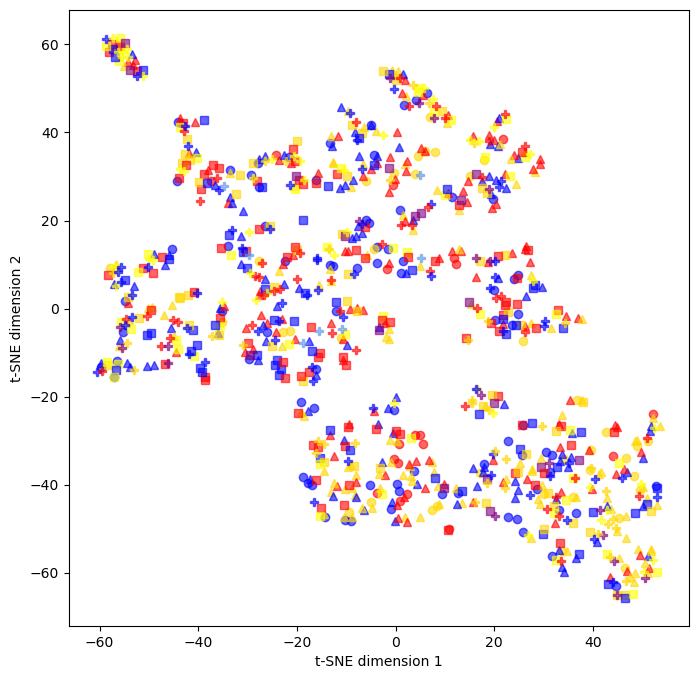

In [121]:
symbol_dict = {(1945,1960):'o',
               (1961,1990):'^',
               (1991,2014):'s',
               (2015,2025):'P'}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}


fig, ax = plt.subplots(1, figsize=(8,8))

for idx,row in enumerate(para_df.iterrows()):
    ax.plot(tsne_results[idx,0], tsne_results[idx,1],
            alpha=0.6, color=party_colors[row[1].party], 
            marker=symbol_dict[[(start,end) for (start,end) in symbol_dict.keys() if row[1].year.year>=start and row[1].year.year<=end][0]])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()

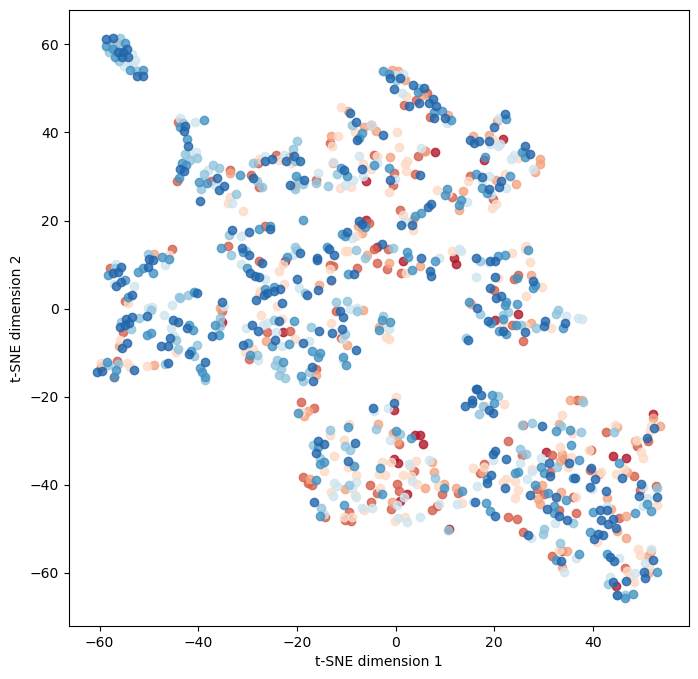

In [128]:
color_dict = {(1945,1950):'#b2182b',
               (1951,1960):'#d6604d',
               (1961,1970):'#f4a582',
               (1971,1980):'#fddbc7',
               (1981,1990):'#d1e5f0',
               (1991,2000):'#92c5de',
               (2001,2010):'#4393c3',
               (2011,2020):'#2166ac'}

fig, ax = plt.subplots(1, figsize=(8,8))

for idx,row in enumerate(para_df.iterrows()):
    ax.plot(tsne_results[idx,0], tsne_results[idx,1],'o',
            alpha=0.8, 
            color=color_dict[[(start,end) for (start,end) in color_dict.keys() if row[1].year.year>=start and row[1].year.year<=end][0]])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()

In [139]:
selected_scaled_X = scaled_X[:,[1,3,4]]
tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=25, n_iter=5000, random_state=0)
tsne_results = tsne.fit_transform(selected_scaled_X)

C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


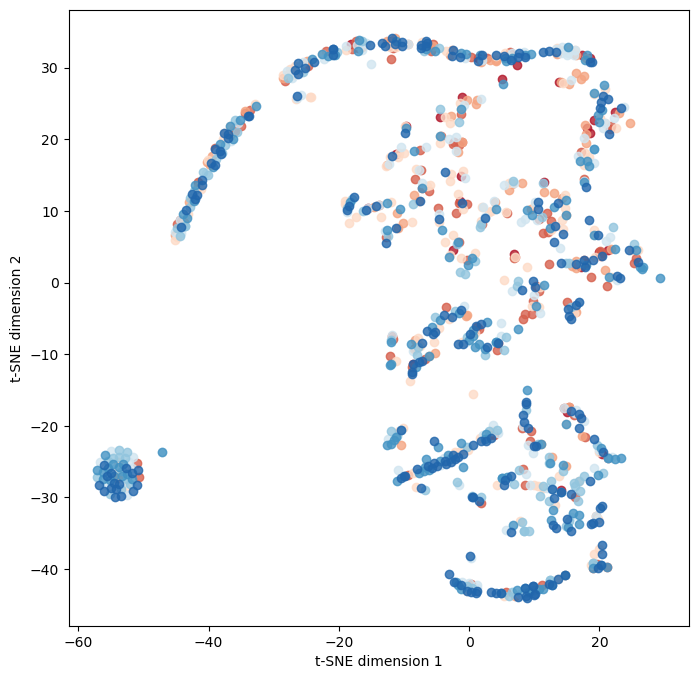

In [140]:
color_dict = {(1945,1950):'#b2182b',
               (1951,1960):'#d6604d',
               (1961,1970):'#f4a582',
               (1971,1980):'#fddbc7',
               (1981,1990):'#d1e5f0',
               (1991,2000):'#92c5de',
               (2001,2010):'#4393c3',
               (2011,2020):'#2166ac'}

fig, ax = plt.subplots(1, figsize=(8,8))

for idx,row in enumerate(para_df.iterrows()):
    ax.plot(tsne_results[idx,0], tsne_results[idx,1],'o',
            alpha=0.8, 
            color=color_dict[[(start,end) for (start,end) in color_dict.keys() if row[1].year.year>=start and row[1].year.year<=end][0]])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()

## Word embeddings

In [82]:
paragraph_vecs = para_df.paragraph.apply(lambda text_list: [vectors[word] if word in vectors.keys() and word not in stops else missing_word for word in text_list])
avg_paragraph_vecs = paragraph_vecs.apply(lambda vecs: list(np.nanmean(vecs, axis=0))).to_list()

nans = [idx for idx,vecs in enumerate(avg_paragraph_vecs) if any([pd.isna(x) for x in vecs])]
avg_paragraph_vecs = [vecs for vecs in avg_paragraph_vecs if not any([pd.isna(x) for x in vecs])]

<ipython-input-82-0bcaf2f34f9f>:2: RuntimeWarning: Mean of empty slice
  avg_paragraph_vecs = paragraph_vecs.apply(lambda vecs: list(np.nanmean(vecs, axis=0))).to_list()


In [105]:
X = np.array(avg_paragraph_vecs)

tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=20, n_iter=5000, random_state=0)
tsne_results = tsne.fit_transform(X)

C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


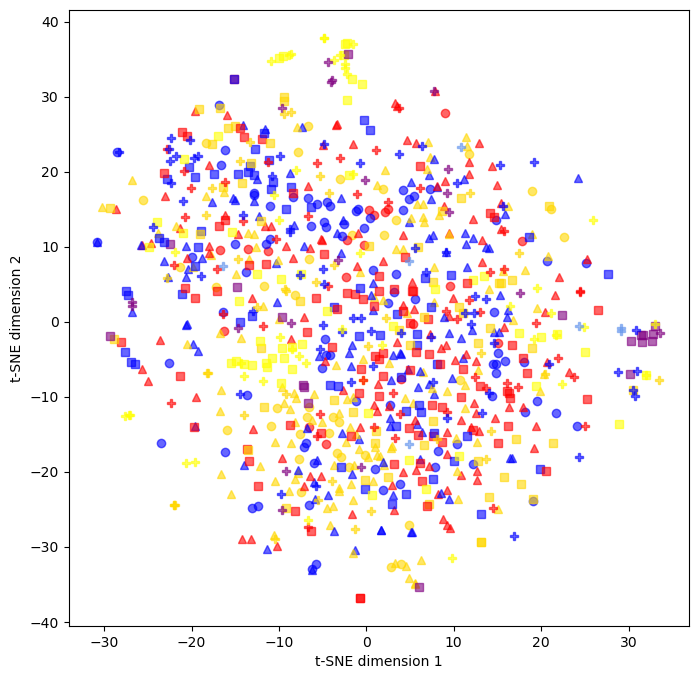

In [106]:
symbol_dict = {(1945,1960):'o',
               (1961,1990):'^',
               (1991,2014):'s',
               (2015,2025):'P'}
party_colors = {'CON':'blue','LAB':'red','LIB':'gold',
                'SNP':'yellow','UKIP':'purple','BRX':'cornflowerblue'}


fig, ax = plt.subplots(1, figsize=(8,8))

for idx,row in enumerate(para_df.drop(nans, axis=0).iterrows()):
    ax.plot(tsne_results[idx,0], tsne_results[idx,1],
            alpha=0.6, color=party_colors[row[1].party], 
            marker=symbol_dict[[(start,end) for (start,end) in symbol_dict.keys() if row[1].year.year>=start and row[1].year.year<=end][0]])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
plt.show()